<a href="https://colab.research.google.com/github/KevinLolochum/Time-Series-Forecasting-Projects/blob/master/Toronto_Parking_Data_Forecasting_revenue_using_Recurrent_Neural_Networks_RNNs(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Predicting Toronto City revenue using previous revenue, weather conditions and holidays

Data sources

1. Canadian holidays dataset https://github.com/uWaterloo/Datasets/blob/master/Holidays/holidays.csv  
2. Toronto temp and seasons dataset https://www.kaggle.com/rainbowgirl/climate-data-toronto-19372018
and https://toronto.weatherstats.ca/download.html
3. Parking tickets  https://open.toronto.ca/dataset/parking-tickets/


In [ ]:
# Importing useful libraries

# For data analysis and visualization
import pandas as pd
import numpy as np
import glob
# for ML and DL
import tensorflow as ts
import keras

In [ ]:
# Connecting to Gdrive to aceess data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading and combining the parking dataset from drive

In [ ]:
filenames = sorted(glob.glob('/content/gdrive/My Drive/Parking_Tags_Data_201*.csv'))
filenames = filenames[:]

def conc(filenames):
  df = pd.DataFrame()
  for filename in filenames:
    data = pd.read_csv(filename, delimiter=',')
    df = df.append(data)
  return df


In [ ]:
df = conc(filenames=filenames[:])
df.head(3)


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***87325,20150101,15.0,PARK-WITHIN 3M OF FIRE HYDRANT,100,1.0,OPP,11 CENTRE AVE,NaN,NaN,ON
1,***87326,20150101,15.0,PARK-WITHIN 3M OF FIRE HYDRANT,100,1.0,OPP,11 CENTRE AVE,NaN,NaN,ON
2,***09493,20150101,3.0,PARK ON PRIVATE PROPERTY,30,2.0,NR,2425 JANE ST,NaN,NaN,ON


Exploring output

In [ ]:
#Checking the shape of data
#df.isna().sum()
#df.dtypes
df.shape

(8611768, 11)

Some cleaning

In [ ]:
# Converting date of infraction to date and set as index
def clean(data):
  df.date_of_infraction = pd.to_datetime(df['date_of_infraction'], 
                                         format='%Y%m%d', errors='ignore')
  dfr = df.set_index('date_of_infraction')

# Aggregate fine amount by date and renaming
# could do better with hourly agg but data is messy

  dfx = dfr['set_fine_amount'].resample('d').sum()
  dfs = pd.DataFrame(dfx)
  dfs = dfs.rename(columns={'set_fine_amount': 'Revenue'})
  return dfs


In [ ]:
df1 = clean(df)
df1.head(2)

,Revenue
date_of_infraction,
2015-01-01,79975
2015-01-02,315130


## Additional data - Weather, Holidays and Seasons

In [ ]:
# Loading from drive
AData = pd.read_csv('/content/gdrive/My Drive/Toronto_weather_and_holidays.csv', delimiter=',', parse_dates=True)

# Set date as index and delete holiday

AData['DATE'] = pd.to_datetime(AData[['Year', 'Month', 'Day']])
Data = AData.set_index('DATE')
Data.pop('Date')
Data.head(2)

,Year,Month,Day,Temp,Rain,Snow,Precip,season,Holiday,Is_holiday
DATE,,,,,,,,,,
2018-01-01,2018,1,1,-15,0,0,0,Winter,New Year's Day,1
2018-01-02,2018,1,2,-11,0,1,1,Winter,NaN,0


In [ ]:
# Creating dummies for seasons
df2 = Data[['Temp', 'Rain', 'Snow', 'Precip', 'season', 'Is_holiday']]
df2 = pd.get_dummies(df2, dummy_na = False)
df2.head(2)

,Temp,Rain,Snow,Precip,Is_holiday,season_Fall,season_Spring,season_Summer,season_Winter
DATE,,,,,,,,,
2018-01-01,-15,0,0,0,1,0,0,0,1
2018-01-02,-11,0,1,1,0,0,0,0,1


Combining the two datasets form our final dataset

In [ ]:
# Pd.merge on date combines horizontally and also implements cross join if
df3 = pd.merge(df2, df1, left_index=True, right_index=True)
df3.head(2)


,Temp,Rain,Snow,Precip,Is_holiday,season_Fall,season_Spring,season_Summer,season_Winter,Revenue
2018-01-01,-15,0,0,0,1,0,0,0,1,63490
2018-01-02,-11,0,1,1,0,0,0,0,1,285635


In [ ]:
# Changing holiday to categorical
df3['Is_holiday'] = df3['Is_holiday'].astype('uint8')

Downloading data to excel

In [ ]:
#df3.to_excel("Toronto_Parking_Data.xlsx", index=True, encoding='utf8')

## EDA

This section will help me decide which model is best for this problem

In [ ]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

#from pandas_profiling import ProfileReport

#Profile = ProfileReport(df3)

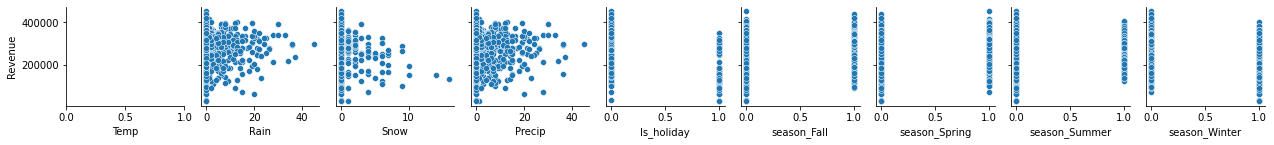

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['Temp', 'Rain', 'Snow', 'Precip', 'Is_holiday', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']

sns.pairplot(df3, x_vars = columns , 
             y_vars = 'Revenue', height = 2);

There is some linear relationship between weather conditions and revenue.


# Modelling

Even though my analysis above indicate indicate that there is some linear relationship between revenue and some some features, this data perfomed very bad on linear models even after regularization. The R_squared (coefficient of determination) for the best linear model was 0.1815.

After testing a few other models such as SVR I decided to use a LSTM time series forecasting model, which performed pretty well as shown below.


## LSTM MODEL

LSTM is ideal for this problem because we are trying to predict future values using current and past values.

LSTM can remember values from the past when they are important and forget when they are no longer important. This is great for example because as seasons and weather change our model will know not to put so much weight on conditions such as snow or precipitation when making predictions.

In [ ]:

df4 = df3


In [ ]:
# Now we have a much larger dataset
df4.shape

(1461, 10)

To apply LSTM I need to convert the time_series data to supervised learning problem

This long code does the following.

1. Takes our data and naively forecasts the next value for each column by simply shifting current value to one period in future.

   i.e we are predicting values at time (t) & t(1-n) using past values. for both outputs and inputs.
2. Aggegates the columns and deletes null values created by shifting values forward.
3. We do this for both features and targets because we also use the target for predicting.

In [ ]:

# prepare data for lstm
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split
 
# convert series to supervised learning

def dataframe_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# n_in, n_out define the lag of input and output, I can increase if I want to predict deeper into the future
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
 
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Col%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Col%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Col%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
  # put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	
  # drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
# Convert  dataframe to numpy array to easily normalize everything
values = df4.values 

# Make data float for normalization
values = values.astype('float32')

# normalize features for model convinience
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# Transforming our dataset into a supervised learning problem using the function
# Columns Colx(t) are values forecasted from Colx(t-x)

df5 = dataframe_to_supervised(scaled)
df5.head(3)

,Col1(t-1),Col2(t-1),Col3(t-1),Col4(t-1),Col5(t-1),Col6(t-1),Col7(t-1),Col8(t-1),Col9(t-1),Col10(t-1),Col1(t),Col2(t),Col3(t),Col4(t),Col5(t),Col6(t),Col7(t),Col8(t),Col9(t),Col10(t)
1,0.132075,0.0,0.0000,0.000000,1.0,0.0,0.0,0.0,1.0,0.088383,0.207547,0.0,0.0625,0.022222,0.0,0.0,0.0,0.0,1.0,0.609038
2,0.207547,0.0,0.0625,0.022222,0.0,0.0,0.0,0.0,1.0,0.609038,0.226415,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.591424
3,0.226415,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.591424,0.132075,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.564483


In [ ]:
df5.shape

(1460, 20)

The new dataset is constructed as a DataFrame, with each column suitably named both by variable number and time step. This allows you to design a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series

In [ ]:
df6 = df5[['Col10(t-1)', 'Col1(t-1)', 'Col2(t-1)', 'Col3(t-1)', 
           'Col4(t-1)', 'Col5(t-1)', 'Col6(t-1)', 'Col7(t-1)', 'Col8(t-1)', 'Col9(t-1)', 'Col10(t)' ]]

df6.head(3)


,Col10(t-1),Col1(t-1),Col2(t-1),Col3(t-1),Col4(t-1),Col5(t-1),Col6(t-1),Col7(t-1),Col8(t-1),Col9(t-1),Col10(t)
1,0.088383,0.132075,0.0,0.0000,0.000000,1.0,0.0,0.0,0.0,1.0,0.609038
2,0.609038,0.207547,0.0,0.0625,0.022222,0.0,0.0,0.0,0.0,1.0,0.591424
3,0.591424,0.226415,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.564483


In [ ]:
# I need a numpy array of values to proceed
values2 = df6.values

#Split to train and test
Len = int(len(values2)*0.8)
train = values2[:Len, :]
test = values2[Len:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1168, 1, 10) (1168,) (292, 1, 10) (292,)


Creating the LSTM Model

In [ ]:

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Creating/Initializing

model = Sequential()
model.add(LSTM(64, input_shape=(1, 10), return_sequences= True, stateful= False))
model.add(Dense(1))

# Compiling
model.compile(loss='mae', optimizer='adam')



Fitting model and evalueting to see accuracy

Epoch 1/15
24/24 [==============================] - 0s 19ms/step - loss: 0.4478 - val_loss: 0.2769
Epoch 2/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1932 - val_loss: 0.1103
Epoch 3/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1256 - val_loss: 0.1066
Epoch 4/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1203 - val_loss: 0.1107
Epoch 5/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1184 - val_loss: 0.1051
Epoch 6/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1185 - val_loss: 0.1037
Epoch 7/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1179 - val_loss: 0.1080
Epoch 8/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1175 - val_loss: 0.1074
Epoch 9/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1170 - val_loss: 0.1033
Epoch 10/15
24/24 [==============================] - 0s 4ms/step - loss: 0.1173 - val_loss: 0.1040
Epoch 11/15
24/24 

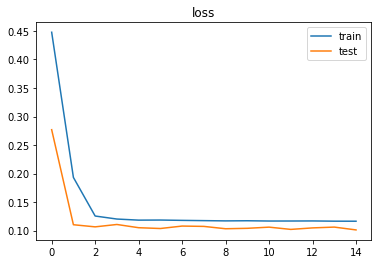

In [ ]:
# params

epochs = 15
BATCH_SIZE = 50
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size= BATCH_SIZE, validation_data=(test_X, test_y), verbose=1, shuffle=True)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss')
plt.legend()
plt.show()


Evaluating model

In [ ]:

from pandas import DataFrame
from pandas import concat
from numpy import concatenate

# Predicting Y values using our test data
yhat = model.predict(test_X)

# Reshape yhat and test_X to 2D in order to combine the two
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
Newtest_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Combine and trenasform to original values (denormalize)
inv_yhat = concatenate((Newtest_X[:, :-1], yhat), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat)
inv_yhat3 = inv_yhat2[:,-1]


In [ ]:
# Invert actual Y values to original scale
Newtest_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((Newtest_X[:, :-1], Newtest_y), axis=1)
inv_y2 = scaler.inverse_transform(inv_y)
inv_y3 = inv_y2[:,-1]

In [ ]:
# calculating Root Mean Squared Error (RMSE)
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y3, inv_yhat3))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 60538.695


Root Mean Square Error (RMSE) for minutes and daily data

`Daily data achieves a good RMSE of ~60K`

In [ ]:
# Comparing actuals and predicted values
# actuals
inv_y3[[1, 50, 100, 150, 200]]

array([308470., 302745., 297465., 314460., 349470.], dtype=float32)

In [ ]:
#predicted
inv_yhat3[[1, 50, 100, 150, 200]]

array([273680.9 , 288317.16, 293992.8 , 307735.06, 307348.16],
      dtype=float32)